Large-Cap Non-Cyclical Value Stock Intrinsic valuation

In [317]:
!pip install yfinance
!pip install yahoofinancials
!pip install yahoo_fin

  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13489 sha256=bc0230077f6b56e69f798de2344051adc3b16f6d7a85826575172dfe218a8538
  Stored in directory: c:\users\jpawe\appdata\local\pip\cache\wheels\a0\b8\b7\8c942b2c5be5158b874a88195116b05ad124bac795f6665e65
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1277 sha256=8a73bd991eb1d16a2dc01134c18341bdaf52c74a7f222ddf2484f6653bca12d7
  Stored in directory: c:\users\jpawe\appdata\local\pip\cache\wheels\75\78\21\68b124549c9bdc94f822c02fb9aa3578a669843f9767776bca
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24584 sha256=8ec8f52fe20765eefa84a054b9c42f54e4ead69b85bc05df1faee6f2e9fd5081
  Stored in directory: c:\users\jpawe\appdata\local\pip\cache\wheels\e5\33\1f\68392720485b3ecf125a69e700baaab7624616deedea2fa6e2
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6070 sha256=57c2afa902583386a25f8b932834b7bdfccaaa34fd27eae9ecd07e9b82a3ffb8

In [318]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
import requests
from bs4 import BeautifulSoup
import re
import yahoo_fin.stock_info as si

$cagr = Analyst\ consensus\ on\ 5-year\ annual\ growth\ rate $

$pe_{1} = 2 * cagr $

$pe_{2} = \frac{1}{20}(\sum\limits_{i=1}^{20} pe_{i}) $

$pe_{k} = Other\ future\ PE\ estimators$ 

$pe = min(pe_{1},\ pe_{2},\ ...,\ pe_{k})$


In [364]:
def phil_town(ticker, minimum_return, name, MoS, plot):
    
    """
    ticker: String, caps
    minimum_return: Float, should be greater than index (if investment not governed by BRF)
    name: String, lowercase
    MoS: Percentage below true value which you wish to buy, typically 50%
    plot: Bool, chart EPS and projected EPS growth
    """
    
    stock_obj = YahooFinancials(ticker)
    price_dict = stock_obj.get_stock_price_data()[ticker]
    current = price_dict['regularMarketPreviousClose']
    currency = price_dict['currency']
    shares = stock_obj.get_num_shares_outstanding()
   
    dfs = pd.read_html(f'https://www.macrotrends.net/stocks/charts/{ticker}/{name}/eps-earnings-per-share-diluted')[0]   
    dfs.rename(columns={list(dfs)[0]:'Year', list(dfs)[1]:'EPS'}, inplace=True)
    dfs.set_index(dfs['Year'], inplace=True)
    dfs['EPS'] = dfs['EPS'].str.replace('$', '').astype(float)
    dfs = dfs.iloc[::-1]
    
    if plot == True:
        fig, ax = plt.subplots(1,1,figsize=(18,14))
        plt.title('Historic EPS')
        plt.plot(dfs['EPS']);
        plt.xticks(rotation=45);
    else:
        pass
    
    cagr = si.get_analysts_info(ticker)['Growth Estimates'][ticker][4]
    cagr = cagr.replace('%','')
    cagr = float(cagr)/100
    
    pe_histo = pd.read_html(f'https://www.macrotrends.net/stocks/charts/{ticker}/{name}/pe-ratio')[0]
    pe_histo.columns = pe_histo.columns.droplevel(0)
    pe_histo.rename(columns={list(pe_histo)[0]:'Year', list(pe_histo)[3]:'PE'}, inplace=True)

    pe1 = float(200 * cagr)
    pe2 = float(pe_histo['PE'].iloc[0:20].mean())
    pe = min(pe1, pe2)
    
    earnings_dict = {0: round(stock_obj.get_earnings_per_share(),2)}
    
    for i in range(1,10):
        j = i - 1
        earnings_dict[i] = round(earnings_dict[j]+(earnings_dict[j] * cagr),2)
        
    if plot == True:
        fig, ax = plt.subplots(1,1,figsize=(18,14))
        plt.title('Forecast EPS Growth')
        plt.plot(earnings_dict.values());
        plt.xticks(rotation=45);
    else:
        pass
    
    fair_price_dict = {9: earnings_dict[9]*pe}
    
    for i in range(8,-1,-1):
        j = i + 1
        fair_price_dict[i] = fair_price_dict[j]/(1+minimum_return)
        
    current_fair_price = round(fair_price_dict[0],2)
    buyable_price = round((current_fair_price * MoS), 2)
    
    if buyable_price > stock_obj.get_daily_high():
        print(f"{ticker}: Cheap\nTarget = <${buyable_price}\nCurrent = ${current}.")
    else:
        print(f'{ticker}: Expensive\nTarget = <${buyable_price}\nCurrent = ${current}')

    return 

MSFT: Expensive
Target = <$125.28
Current = $305.22


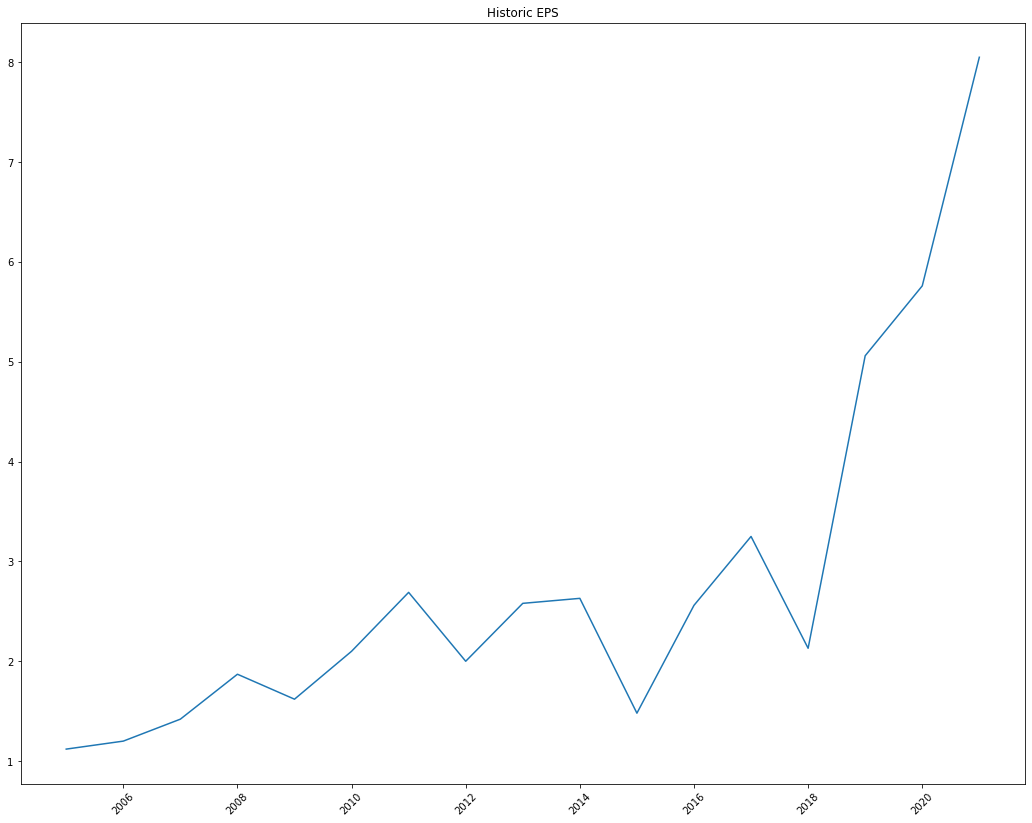

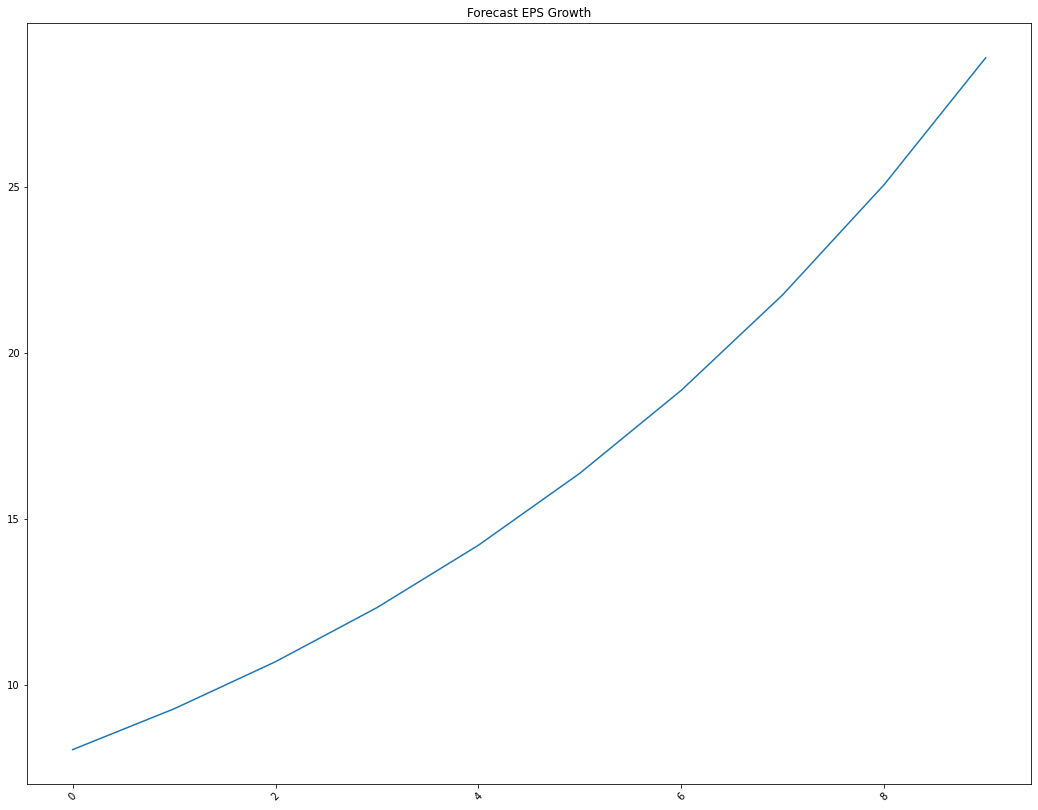

In [391]:
phil_town('MSFT', 0.15, 'microsoft', 0.5, True)

In [392]:
firm_dict= {'UNP': 'union-pacific', 'GD':'general-dynamics'}

In [393]:
for x, y in firm_dict.items():
    phil_town(x, 0.15, y, 0.5, False)

UNP: Expensive
Target = <$76.38
Current = $203.44
GD: Expensive
Target = <$53.34
Current = $194.88
